# **Exercise 05/B - clustering with Jensen-Shannon**
### Laboratory of **Computational Physics**, module B
#### University of **Padua**, *AY 2021/2022* 

### Group **02**
#### *Students:* Barone Francesco Pio, Nagaro Quiroz Gianmarco, Ninni Daniele, Valentini Lorenzo

***

In this notebook:

0) [Dataset](#sec_dataset)
1) [t-SNE visualization](#sec_tsne)
    - [t-SNE for clustering?](#sec_tsne_kmeans)
    - [t-SNE with PCA initialization](#sec_tsne_pca)
2) [DBSCAN (eps & NMI)](#sec_dbscan)
4) [t-SNE on more similar probability distributions](#sec_nasty)
    - [the 'infamous' dataset](#sec_infamous)
5) [Hierarchical clustering](#sec_hc)
    - [nasty dataset](#sec_hc_nasty)
    - [infamous dataset](#sec_hc_infamous)
***

### setup

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14
import scipy
import pickle
from matplotlib.colors import ListedColormap
from matplotlib.ticker import NullFormatter
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from collections import OrderedDict
from sklearn.preprocessing import StandardScaler
from sklearn import manifold
from sklearn.cluster import KMeans
from time import time
from time import perf_counter

from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, fowlkes_mallows_score


# NOTE: to work with the scipy JS metric you need version 1.8 or above...
print('Scipy:',scipy.__version__)
import scipy.spatial.distance as spd
# .. otherwise, use     import scipy.spatial.distance as spd
#  and use the metric   spd.jensenshannon

np.random.seed(123456)

# tsne settings
n_components = 2

# general settings
n_jobs = 24
do_backup_tsne = True

data_path = 'DATA'

Scipy: 1.8.0


<a id='sec_dataset'></a>
### **0** - dataset

In this notebook we will use 3 different datasets. Each dataset has been generated in the same way (look at the dedicated notebook) but with different probability distribution functions $P_i$.
- a **standard dataset**: 4 distributions peaked in different intervals, so that they are trivially separable by looking at the highest frequency bin
![img_std_dataset](DATA/std_data_preview.png)
- a **'nasty' dataset**: 5 distributions with partially overlapping peak values 
![img_nasty_dataset](DATA/nasty_data_preview.png)
- an **'infamous' dataset**: 5 distributions whose peak values are placed almost at the right border of the bins
![img_infamous_dataset](DATA/infamous_data_preview.png)

<a id='sec_tsne'></a>
## **1** - t-SNE visualization

Let us start from the **standard dataset**.

In [2]:
fname, fnamey = "x_distr.txt", "y_distr.txt"

x = np.loadtxt(f'{data_path}/{fname}', delimiter=" ")
y = np.loadtxt(f'{data_path}/{fnamey}')
y.astype(int)

print(f'{len(x)} samples from file')

N = 2000

if N < len(x):
    x, y = x[:N], y[:N]
else:
    N = len(x)
    
D = len(x[0])
print("final dataset:  N =", N, "  D =", D)

10000 samples from file
final dataset:  N = 2000   D = 9


In [3]:
perplexities = [20, 50, 100]
Np = len(perplexities)

Yres = {}
for i, perplexity in enumerate(perplexities):
    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, random_state=123456, 
                         perplexity=perplexity, metric=spd.jensenshannon, 
                         learning_rate=200, n_iter=1000, 
                         n_iter_without_progress=300, min_grad_norm=1e-7, 
                         init="random", verbose=1, 
                         method="exact", n_jobs=n_jobs, square_distances='legacy')
    Y = tsne.fit_transform(x)
    t1 = time()
    print(f'perplexity {perplexity} completed in {t1-t0}')
    Yres[str(perplexity)] = Y.copy()

[t-SNE] Computing pairwise distances...


/home/baronefr/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.050438
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.520719
[t-SNE] KL divergence after 1000 iterations: 1.368512
perplexity 20 completed in 121.10017943382263
[t-SNE] Computing pairwise distances...


/home/baronefr/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.058915
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.927228
[t-SNE] KL divergence after 1000 iterations: 1.196049
perplexity 50 completed in 112.06859970092773
[t-SNE] Computing pairwise distances...


/home/baronefr/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.067035
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.777347
[t-SNE] KL divergence after 1000 iterations: 0.937813
perplexity 100 completed in 113.54313111305237


In [4]:
if do_backup_tsne:
    with open(f'{data_path}/tsne_std_dataset.pkl', 'wb') as output:
        pickle.dump(Yres, output)

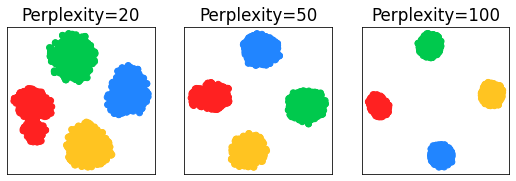

In [5]:
# plot
(fig, subplots) = plt.subplots(1, Np, figsize=(3*Np, 2.7))
mycmap = ListedColormap(['#ff2121', '#ffc421', '#00c94d', '#2185ff'])

for i, perplexity in enumerate(perplexities):
    ax = subplots[i]
    Y = Yres[str(perplexity)]
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:,0], Y[:,1], c=y, cmap=mycmap)
    ax.tick_params(left=False, bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

<a id='sec_tsne_kmeans'></a>
### **1.1** - t-SNE for clustering?

Since we see that t-SNE is able to clearly separate the 4 clusters of our data distributions, we can use the 2-dimensional output to run a k-means clustering before using more advanced methods (hierarchical clustering).

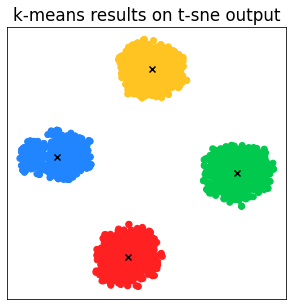

In [6]:
Y = Yres['50']  # select perplexity = 50

kmeans = KMeans(n_clusters=4, random_state=0).fit(Y)
#print(kmeans.labels_)

mycmap = ListedColormap(['#ff2121', '#ffc421', '#00c94d', '#2185ff'])

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_title("k-means results on t-sne output")
ax.scatter(Y[:,0], Y[:,1], c=kmeans.predict(Y), cmap=mycmap)
ax.tick_params(left=False, bottom=False)
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.axis('tight')

ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],c='k', marker='x')
plt.show()

<a id='sec_tsne_pca'></a>
### **1.2** - t-SNE with PCA initialization

Still using the **standard dataset**.

In [7]:
perplexities = [20, 50, 100]
Np = len(perplexities)

Yres_pca = {}
for i, perplexity in enumerate(perplexities):
    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, random_state=123456, 
                         perplexity=perplexity, metric=spd.jensenshannon, 
                         learning_rate=200, n_iter=1000, 
                         n_iter_without_progress=300, min_grad_norm=1e-7, 
                         init="pca", verbose=1, 
                         method="exact", n_jobs=n_jobs, square_distances='legacy')
    Y = tsne.fit_transform(x)
    t1 = time()
    print(f'perplexity {perplexity} completed in {t1-t0}')
    Yres_pca[str(perplexity)] = Y.copy()

/home/baronefr/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.050438


/home/baronefr/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.392303
[t-SNE] KL divergence after 1000 iterations: 1.367677
perplexity 20 completed in 115.1772894859314
[t-SNE] Computing pairwise distances...


/home/baronefr/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.058915


/home/baronefr/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.706866
[t-SNE] KL divergence after 1000 iterations: 1.200298
perplexity 50 completed in 113.63113832473755
[t-SNE] Computing pairwise distances...


/home/baronefr/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.067035


/home/baronefr/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.673229
[t-SNE] KL divergence after 1000 iterations: 0.949285
perplexity 100 completed in 114.9243495464325


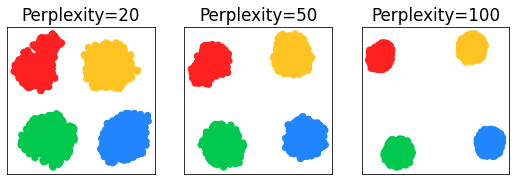

In [8]:
# plot
(fig, subplots) = plt.subplots(1, Np, figsize=(3*Np, 2.7))
mycmap = ListedColormap(['#ff2121', '#ffc421', '#00c94d', '#2185ff'])

for i, perplexity in enumerate(perplexities):
    ax = subplots[i]
    Y = Yres_pca[str(perplexity)]
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:,0], Y[:,1], c=y, cmap=mycmap)
    ax.tick_params(left=False, bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

<a id='sec_dbscan'></a>
## **2** - DBSCAN (eps & NMI)

#### Find the typical minimum distance between points
This yields a typical scale, to be used as a reference for "eps".

In [9]:
min_d_vector = np.zeros(N)

for i in range(N):
    min_d_frompoint = 10e5
    for j in range(N):
        if i!=j:
            dij = spd.jensenshannon(x[i], x[j])
            if dij < min_d_frompoint:
                min_d_frompoint = dij
    min_d_vector[i] = min_d_frompoint
mean_min_d = min_d_vector.mean()
print("mean minimum distance between points: ",mean_min_d)

mean minimum distance between points:  0.01719680285482567


We select the t-SNE output with `perplexity = 50` and `init='pca'`.

In [10]:
X2D = Yres_pca['50']  # best visualization above
X = x
y_true = y

In [11]:
cpalette = ["blue","red","gold","black","magenta","green","cyan","#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]
ms = 6

def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

# Normalized mutual information function
#  Note: that this deals with the label permutation problem
def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)

def plotting_ax(X, y, ax):
    # plotting function
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=ms)

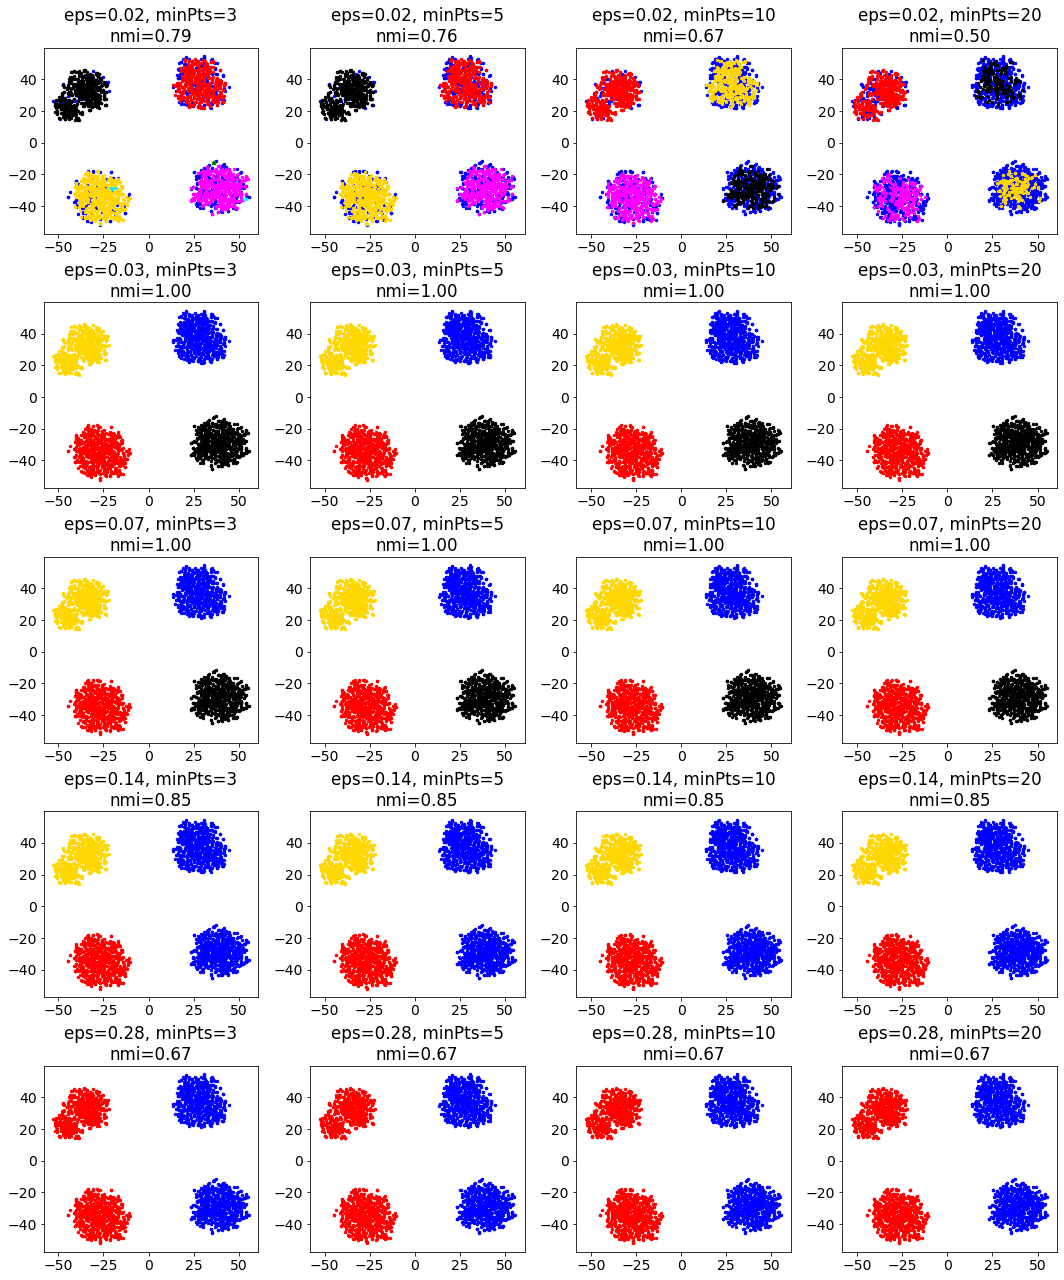

In [12]:
# DBSCAN has a few parameters, let's sweep over a few parameters and see what happens
np.random.seed(12345)
n_true_center=3

eps_range = [0.01,0.1,0.5,1.0,10.]
if mean_min_d<10:
    r=mean_min_d
else:
    r = int(mean_min_d)
eps_range = [r,2*r,4*r,8*r,16*r]
min_sample_range = [3,5,10,20]
fig, ax = plt.subplots(len(eps_range),len(min_sample_range),figsize=(15,18))
for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y_hat = model.labels_
        plotting_ax(X2D,y_hat,ax[i,j])
        nmi=NMI(y_hat, y_true)
        ax[i,j].set_title('eps=%.2f, minPts=%i\nnmi=%.2f'%(eps,min_samples,nmi))
plt.tight_layout(h_pad=0.5)
plt.show()

We are able to find some values of eps & NMI for which the clusters are correctly separated.

<a id='sec_nasty'></a>
## **3** - t-SNE on more similar probability distributions

Now we test the **'nasty'** and **'infamous'** dataset.

In [13]:
fname, fnamey = "x_distr_nasty.txt", "y_distr_nasty.txt"

x = np.loadtxt(f'{data_path}/{fname}', delimiter=" ")
y = np.loadtxt(f'{data_path}/{fnamey}')
y.astype(int)

print(f'{len(x)} samples from file')

N = 2000

if N < len(x):
    x, y = x[:N], y[:N]
else:
    N = len(x)
    
D = len(x[0])
print("final dataset:  N =", N, "  D =", D)

10000 samples from file
final dataset:  N = 2000   D = 9


In [14]:
np.random.seed(123456)

perplexities = [20, 50, 100]
Np = len(perplexities)

Yres_nasty = {}
for i, perplexity in enumerate(perplexities):
    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, random_state=123456, 
                         perplexity=perplexity, metric=spd.jensenshannon, 
                         learning_rate=200, n_iter=1000, 
                         n_iter_without_progress=300, min_grad_norm=1e-7, 
                         init="random", verbose=1, 
                         method="exact", n_jobs=n_jobs, square_distances='legacy')
    Y = tsne.fit_transform(x)
    t1 = time()
    print(f'perplexity {perplexity} completed in {t1-t0}')
    Yres_nasty[str(perplexity)] = Y.copy()

[t-SNE] Computing pairwise distances...


/home/baronefr/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.051791
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.326596
[t-SNE] KL divergence after 1000 iterations: 1.287047
perplexity 20 completed in 113.28245997428894
[t-SNE] Computing pairwise distances...


/home/baronefr/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.060829
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.672021
[t-SNE] KL divergence after 1000 iterations: 1.082879
perplexity 50 completed in 114.23432612419128
[t-SNE] Computing pairwise distances...


/home/baronefr/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.069911
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.749132
[t-SNE] KL divergence after 1000 iterations: 0.831579
perplexity 100 completed in 112.2865297794342


In [15]:
if do_backup_tsne:
    with open(f'{data_path}/tsne_nasty_dataset.pkl', 'wb') as output:
        pickle.dump(Yres_nasty, output)

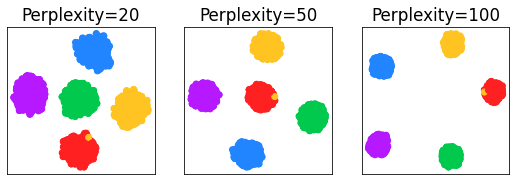

In [16]:
# plot
(fig, subplots) = plt.subplots(1, Np, figsize=(3*Np, 2.7))
mycmap = ListedColormap(['#ff2121', '#ffc421', '#00c94d', '#2185ff', '#b619ff'])

for i, perplexity in enumerate(perplexities):
    ax = subplots[i]
    Y = Yres_nasty[str(perplexity)]
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:,0], Y[:,1], c=y, cmap=mycmap)
    ax.tick_params(left=False, bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

We see that in the red cluster there is a small yellow dot. Looking back at the data we are using, it means that there is a sample from the normal distibution (label: 1) which is clustered along the samples from the poisson distribution (label: 2). This is actually a negligible mistake, since those distributions have been on purpose generated to be similiar (i.e. they have the same peak value).

<a id='sec_infamous'></a>
### **3.1** - the 'infamous' dataset

In [17]:
fname, fnamey = "x_distr_infamous.txt", "y_distr_infamous.txt"

x = np.loadtxt(f'{data_path}/{fname}', delimiter=" ")
y = np.loadtxt(f'{data_path}/{fnamey}')
y.astype(int)

print(f'{len(x)} samples from file')

N = 2000

if N < len(x):
    x, y = x[:N], y[:N]
else:
    N = len(x)
    
D = len(x[0])
print("final dataset:  N =", N, "  D =", D)

10000 samples from file
final dataset:  N = 2000   D = 9


In [18]:
np.random.seed(123456)

perplexities = [20, 50, 100]
Np = len(perplexities)

Yres_infamous = {}
for i, perplexity in enumerate(perplexities):
    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, random_state=123456, 
                         perplexity=perplexity, metric=spd.jensenshannon, 
                         learning_rate=200, n_iter=1000, 
                         n_iter_without_progress=300, min_grad_norm=1e-7, 
                         init="pca", verbose=1, 
                         method="exact", n_jobs=n_jobs, square_distances='legacy')
    Y = tsne.fit_transform(x)
    t1 = time()
    print(f'perplexity {perplexity} completed in {t1-t0}')
    Yres_infamous[str(perplexity)] = Y.copy()

[t-SNE] Computing pairwise distances...


/home/baronefr/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.052715


/home/baronefr/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.205271
[t-SNE] KL divergence after 1000 iterations: 1.196662
perplexity 20 completed in 113.64218330383301
[t-SNE] Computing pairwise distances...


/home/baronefr/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.061889


/home/baronefr/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.543019
[t-SNE] KL divergence after 1000 iterations: 1.011200
perplexity 50 completed in 111.97074913978577
[t-SNE] Computing pairwise distances...


/home/baronefr/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.071077


/home/baronefr/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.594104
[t-SNE] KL divergence after 1000 iterations: 0.777793
perplexity 100 completed in 113.15187048912048


In [19]:
if do_backup_tsne:
    with open(f'{data_path}/tsne_infamous_dataset.pkl', 'wb') as output:
        pickle.dump(Yres_infamous, output)

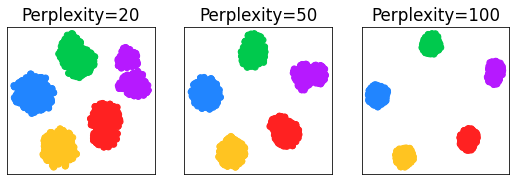

In [20]:
# plot
(fig, subplots) = plt.subplots(1, Np, figsize=(3*Np, 2.7))
mycmap = ListedColormap(['#ff2121', '#ffc421', '#00c94d', '#2185ff', '#b619ff'])

for i, perplexity in enumerate(perplexities):
    ax = subplots[i]
    Y = Yres_infamous[str(perplexity)]
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:,0], Y[:,1], c=y, cmap=mycmap)
    ax.tick_params(left=False, bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

From the t-SNE results, we see that the algorithm is able to distinguish all the 5 distributions, even if the dataset has been generated with almost overlapping distributions.
![img_infamous_dataset](DATA/infamous_data_preview.png)

<a id='sec_hc'></a>
## **4** - Hierarchical clustering

In this section hierarchical clustering is performed using the object `AgglomerativeClustering` available in *sklearn*.

The metric `jensenshannon` available in *scipy* is used to compute the linkage.

The corresponding dendrogram, i.e. the tree representing the hierarchical merging of clusters, is plotted using the object `dendrogram` available in *scipy*.

In addition, since we know the ground truth class assignments, it is possible to evaluate clustering performance using the metrics `adjusted_rand_score` and `fowlkes_mallows_score` available in *sklearn* (https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation).

#### Define the function that plots the dendrogram

In [2]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html

def plot_dendrogram(model, **kwargs):
    # create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

#### Define the function that fits a specific `AgglomerativeClustering` model

In [3]:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html

def agglomerative_clustering(n_clusters=None, linkage_type='average', distance_threshold=0):

    model = AgglomerativeClustering(n_clusters=n_clusters, # number of clusters to find
                                    affinity='jensenshannon',
                                    connectivity=None,
                                    compute_full_tree=True,
                                    linkage=linkage_type,
                                    distance_threshold=distance_threshold,
                                    compute_distances=False)

    print(f'LINKAGE TYPE: "{linkage_type}"')
    print('Fitting...')
    start = perf_counter()
    model = model.fit(x)
    end = perf_counter()
    print(f'Done! Elapsed time: {round(end-start, 2)} s\n')

    return model

<a id='sec_hc_nasty'></a>
### **4.1** - nasty dataset (`n_clusters = 5`)

#### Load data from file

In [4]:
fnamex = 'x_distr_nasty.txt'
x = np.loadtxt('DATA/'+fnamex, delimiter=' ') # data

N = x.shape[0] # number of samples
D = x.shape[1] # data dimensionality
print("Number of samples:", N, "\nData dimensionality:", D)

Number of samples: 10000 
Data dimensionality: 9


#### Fit `AgglomerativeClustering` models corresponding to different linkage types without setting `n_clusters`

In [5]:
linkage_types = ['complete', 'average', 'single'] # 'ward' only works with Euclidean distances!
nasty_models = {}

for linkage_type in linkage_types:
    nasty_models[linkage_type] = agglomerative_clustering(n_clusters=None, linkage_type=linkage_type, distance_threshold=0)

LINKAGE TYPE: "complete"
Fitting...
Done! Elapsed time: 14.61 s

LINKAGE TYPE: "average"
Fitting...
Done! Elapsed time: 14.71 s

LINKAGE TYPE: "single"
Fitting...
Done! Elapsed time: 11.66 s



#### Plot the dendrograms corresponding to the various linkage types

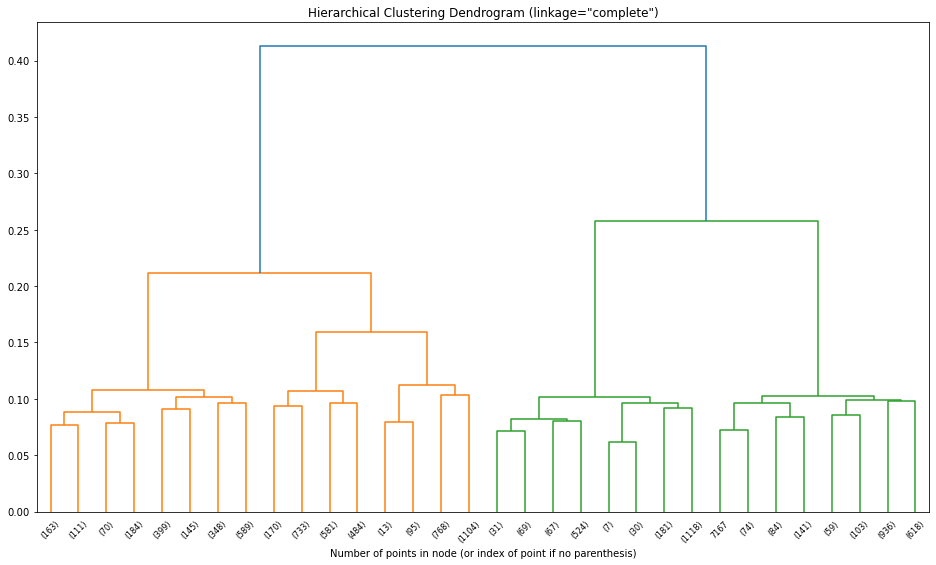

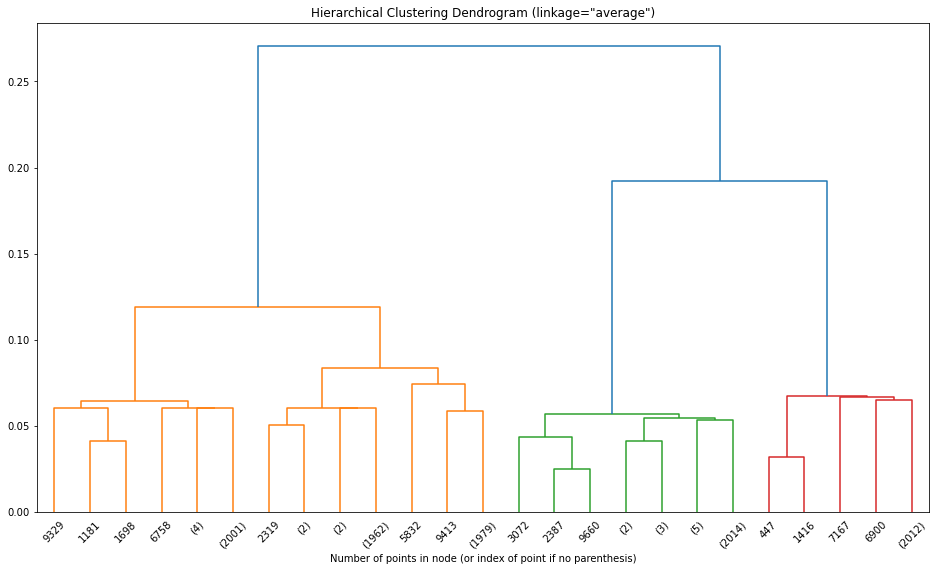

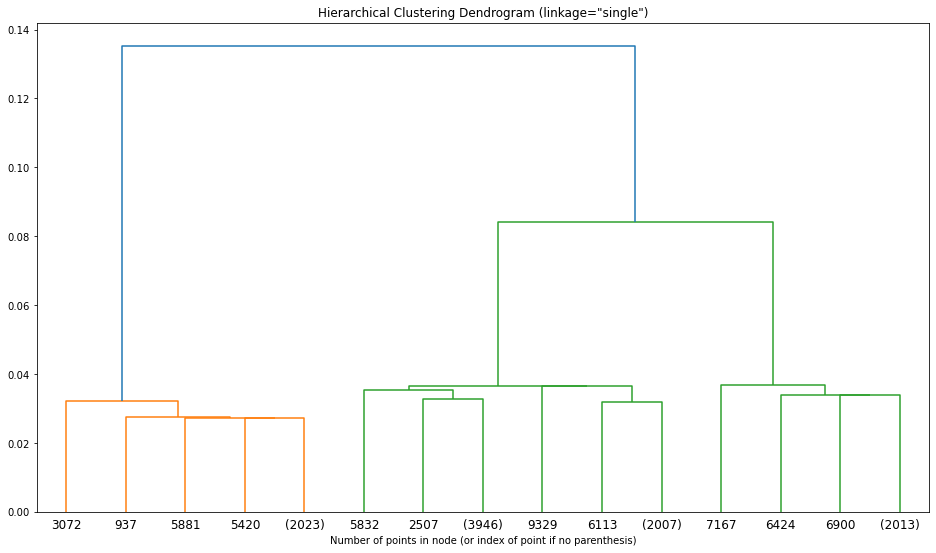

In [6]:
for i in nasty_models:
    plt.figure(figsize=(16,9))
    plt.title(f'Hierarchical Clustering Dendrogram (linkage="{i}")')
    plot_dendrogram(nasty_models[i], truncate_mode='level', p=4) # plot the top 'p' levels of the dendrogram
    plt.xlabel('Number of points in node (or index of point if no parenthesis)')

#### Fit `AgglomerativeClustering` models corresponding to different linkage types setting `n_clusters = 5`

In [7]:
linkage_types = ['complete', 'average', 'single'] # 'ward' only works with Euclidean distances!
nasty_models_5 = {}

for linkage_type in linkage_types:
    nasty_models_5[linkage_type] = agglomerative_clustering(n_clusters=5, linkage_type=linkage_type, distance_threshold=None)

LINKAGE TYPE: "complete"
Fitting...
Done! Elapsed time: 14.41 s

LINKAGE TYPE: "average"
Fitting...
Done! Elapsed time: 14.28 s

LINKAGE TYPE: "single"
Fitting...
Done! Elapsed time: 11.73 s



#### Evaluate clustering performance

In [8]:
# load labels from file
fnamey = 'y_distr_nasty.txt'
y = np.loadtxt('DATA/'+fnamey, delimiter=' ', dtype=int) # labels

for i in nasty_models_5:
    y_predicted = nasty_models_5[i].fit_predict(x)
    print(f'LINKAGE TYPE: "{i}"')
    print('Adjusted Rand index score:', round(adjusted_rand_score(y, y_predicted), 4))
    print('Fowlkes-Mallows index score:', round(fowlkes_mallows_score(y, y_predicted), 4), '\n')

LINKAGE TYPE: "complete"
Adjusted Rand index score: 0.9993
Fowlkes-Mallows index score: 0.9994 

LINKAGE TYPE: "average"
Adjusted Rand index score: 0.999
Fowlkes-Mallows index score: 0.9992 

LINKAGE TYPE: "single"
Adjusted Rand index score: 0.7873
Fowlkes-Mallows index score: 0.8481 



### Results

To evaluate the performance of the clustering algorithm, we use two different scoring metrics from [scikit-learn](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation).

| Linkage type | Adjusted Rand index score | Fowlkes-Mallows index score |
| :-: | :-: | :-: |
| *complete* | 0.9993 | 0.9994 |
|  *average* | 0.9990 | 0.9992 |
|   *single* | 0.7873 | 0.8481 |

The two scoring metrics agree that:
- both *complete* and *average* lead to significantly better results than those obtained with *single*
- both *complete* and *average* lead to an almost perfect clustering of the **nasty** dataset

<a id='sec_hc_infamous'></a>
### **4.2** - infamous dataset (`n_clusters = 5`)

#### Load data from file

In [9]:
fnamex = 'x_distr_infamous.txt'
x = np.loadtxt('DATA/'+fnamex, delimiter=' ') # data

N = x.shape[0] # number of samples
D = x.shape[1] # data dimensionality
print("Number of samples:", N, "\nData dimensionality:", D)

Number of samples: 10000 
Data dimensionality: 9


#### Fit `AgglomerativeClustering` models corresponding to different linkage types without setting `n_clusters`

In [10]:
linkage_types = ['complete', 'average', 'single'] # 'ward' only works with Euclidean distances!
infamous_models = {}

for linkage_type in linkage_types:
    infamous_models[linkage_type] = agglomerative_clustering(n_clusters=None, linkage_type=linkage_type, distance_threshold=0)

LINKAGE TYPE: "complete"
Fitting...
Done! Elapsed time: 14.51 s

LINKAGE TYPE: "average"
Fitting...
Done! Elapsed time: 14.48 s

LINKAGE TYPE: "single"
Fitting...
Done! Elapsed time: 11.48 s



#### Plot the dendrograms corresponding to the various linkage types

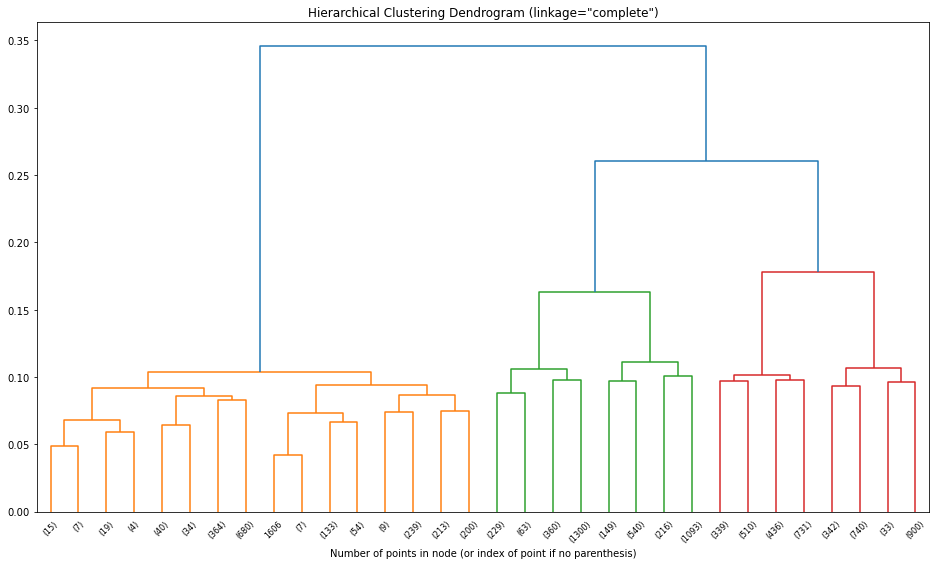

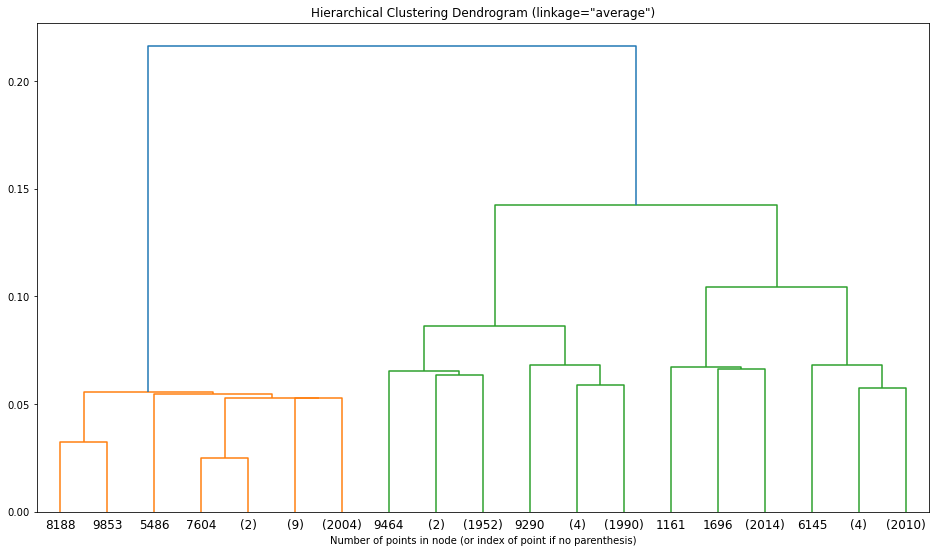

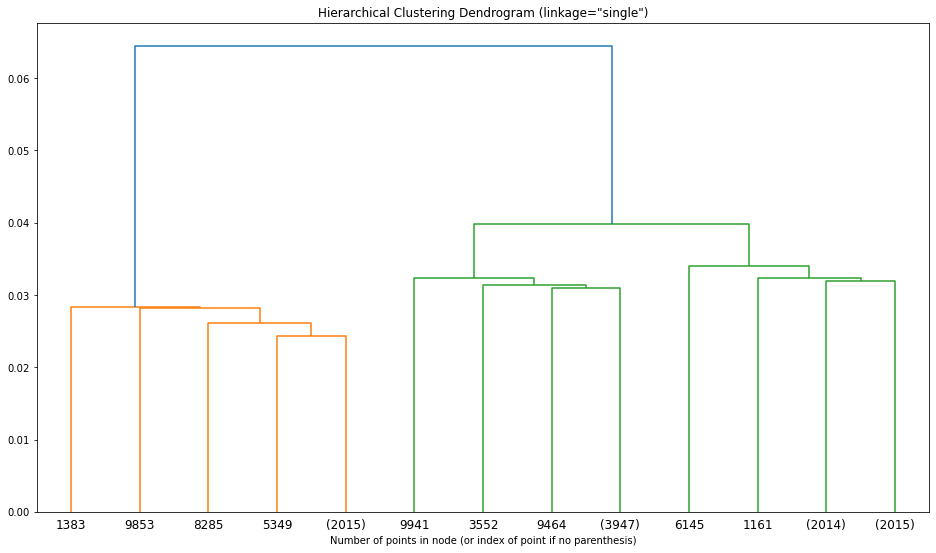

In [11]:
for i in infamous_models:
    plt.figure(figsize=(16,9))
    plt.title(f'Hierarchical Clustering Dendrogram (linkage="{i}")')
    plot_dendrogram(infamous_models[i], truncate_mode='level', p=4) # plot the top 'p' levels of the dendrogram
    plt.xlabel('Number of points in node (or index of point if no parenthesis)')

#### Fit `AgglomerativeClustering` models corresponding to different linkage types setting `n_clusters = 5`

In [12]:
linkage_types = ['complete', 'average', 'single'] # 'ward' only works with Euclidean distances!
infamous_models_5 = {}

for linkage_type in linkage_types:
    infamous_models_5[linkage_type] = agglomerative_clustering(n_clusters=5, linkage_type=linkage_type, distance_threshold=None)

LINKAGE TYPE: "complete"
Fitting...
Done! Elapsed time: 14.04 s

LINKAGE TYPE: "average"
Fitting...
Done! Elapsed time: 14.51 s

LINKAGE TYPE: "single"
Fitting...
Done! Elapsed time: 11.53 s



#### Evaluate clustering performance

In [13]:
# load labels from file
fnamey = 'y_distr_infamous.txt'
y = np.loadtxt('DATA/'+fnamey, delimiter=' ', dtype=int) # labels

for i in infamous_models_5:
    y_predicted = infamous_models_5[i].fit_predict(x)
    print(f'LINKAGE TYPE: "{i}"')
    print('Adjusted Rand index score:', round(adjusted_rand_score(y, y_predicted), 4))
    print('Fowlkes-Mallows index score:', round(fowlkes_mallows_score(y, y_predicted), 4), '\n')

LINKAGE TYPE: "complete"
Adjusted Rand index score: 0.9988
Fowlkes-Mallows index score: 0.999 

LINKAGE TYPE: "average"
Adjusted Rand index score: 0.9988
Fowlkes-Mallows index score: 0.999 

LINKAGE TYPE: "single"
Adjusted Rand index score: 0.6166
Fowlkes-Mallows index score: 0.7459 



### Results

| Linkage type | Adjusted Rand index score | Fowlkes-Mallows index score |
| :-: | :-: | :-: |
| *complete* | 0.9988 | 0.9990 |
|  *average* | 0.9988 | 0.9990 |
|   *single* | 0.6166 | 0.7459 |

The results are similar to those obtained on the **nasty** dataset. In particular, the two scoring metrics agree that:
- both *complete* and *average* lead to significantly better results than those obtained with *single*
- both *complete* and *average* lead to an almost perfect clustering of the **infamous** dataset

End of file.